In [1]:
NOTE = 'XGBoostベクトルは除外しBatterIDでGroupKFold'
notebook_name = '084'
CV = 'GroupK-Fold(batterID)'
group_col = 'batterID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

084_submission.csv 084


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [7]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [313,
  229,
  140,
  340,
  118,
  335,
  321,
  151,
  624,
  183,
  239,
  111,
  184,
  295,
  60,
  82,
  127,
  132,
  572,
  303,
  182,
  311,
  276,
  72,
  55,
  185],
 '1': [349,
  91,
  496,
  443,
  121,
  5,
  105,
  73,
  391,
  535,
  149,
  12,
  412,
  0,
  196,
  509,
  193,
  114,
  582,
  574,
  58,
  2,
  462,
  224,
  26],
 '2': [22,
  556,
  47,
  444,
  9,
  646,
  523,
  449,
  601,
  217,
  201,
  374,
  84,
  402,
  557,
  381,
  261,
  330,
  150,
  135,
  492,
  70,
  628,
  203,
  498],
 '3': [644,
  220,
  148,
  253,
  168,
  27,
  271,
  392,
  192,
  39,
  368,
  485,
  87,
  145,
  619,
  333,
  264,
  36,
  480,
  355,
  98,
  432,
  34,
  164],
 '4': [328,
  636,
  85,
  269,
  362,
  18,
  112,
  555,
  661,
  138,
  475,
  21,
  654,
  500,
  80,
  565,
  510,
  416,
  37,
  153,
  559,
  479,
  293],
 '5': [620,
  446,
  417,
  226,
  263,
  171,
  427,
  199,
  642,
  15,
  488,
  130,
  540,
  418,
  45,
  458,
  67,
  191,
  537,
  301,

In [13]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    """
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    """
    ## descrete features
    """
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    """
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = X_train[discrete_features + categorical_features]
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = X_valid[discrete_features + categorical_features]
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = test[discrete_features + categorical_features]
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
    class_weight = compute_class_weight('balanced',
                                        classes=np.sort(train.y.unique()),
                                        y=y_train.values)
    class_weight = dict(
        zip(
            np.sort(train.y.unique()),
            class_weight
        )
    )
    sample_weight = y_train.map(class_weight)
    assert(sample_weight.isnull().sum() == 0)
#     sample_weight = None
    # classification    
    clf = XGBClassifier(n_jobs=-1,
                        n_estimators=500,
                        learning_rate=0.01,
                        random_state=SEED)
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 1)**********
[[1937 1111  638  598  509  371   37  396]
 [ 492 2127  351  360  311  226   24  255]
 [ 289  360  937  367  305  174   11  179]
 [ 197  226  147  971  168   90   12   84]
 [  27   29   23   26  416   30    2   23]
 [   0    1    0    0    0  163    0    1]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 1)**********
[[205 191  34 136 105  43   9  13]
 [118 222  36  58  48  24   5  25]
 [ 80  91  34  58  61  31   3  12]
 [ 28  54  16  78  40  12   1  12]
 [ 22  15   5  18  25  10   0   4]
 [  2   3   0   6   6   4   0   1]
 [  2   0   0   0   0   0   0   0]
 [  2   5   1   1   2   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 2)**********
[[1952 1162  619  584  513  367   47  404]
 [ 542 2110  342  372  285  247   42  285]
 [ 312  370  930  367  299  170   16  202]
 [ 198  211  149  992  158   87   16  129]
 [  22   33   17   31  439   29    3   25]
 [   0    0    0    0    0  160    0    2]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 2)**********
[[185 154  81  88  96  36   5  40]
 [ 76 192  41  49  48  23   3  25]
 [ 56  64  42  74  56  10   3  21]
 [ 30  41  14  57  30   7   2  15]
 [ 15   9  12  16  15   5   0   4]
 [  7   3   2   5   5   0   1   2]
 [  0   0   0   0   0   0   0   1]
 [  1   2   2   2   4   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:58:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 3)**********
[[2002 1155  562  637  489  376   19  421]
 [ 521 2138  332  379  282  224   17  287]
 [ 324  388  872  399  296  184   10  201]
 [ 174  236  149 1013  143   96    8  108]
 [  24   38   20   34  424   35    3   31]
 [   0    0    1    0    0  159    0    5]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  106]]

**********Confusion matrix for validation set (Fold 3)**********
[[203 211  40  74  64  22   6  52]
 [111 203  30  47  39  23   2  47]
 [ 65  66  42  59  47  21   0  18]
 [ 52  41  29  42  26  12   0   7]
 [ 13  14   9  10   9   4   0   7]
 [  1   7   4   1   2   1   0   6]
 [  0   1   0   0   0   0   0   0]
 [  1   5   1   4   2   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:59:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 4)**********
[[1909 1106  622  625  464  377   38  429]
 [ 510 2065  366  365  287  224   35  291]
 [ 308  367  968  361  279  160   13  186]
 [ 154  204  116 1066  134   86   10  123]
 [  29   31   18   26  424   31    3   41]
 [   0    0    0    0    1  157    0    3]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  102]]

**********Confusion matrix for validation set (Fold 4)**********
[[242 196  56  97  97  20   2  53]
 [103 230  39  73  45  12   2  35]
 [ 68  65  43  85  49  11   0  29]
 [ 45  43  25  61  41   9   2  17]
 [ 15   5   4  20  12   6   0  10]
 [  4   3   5   6   3   2   0   3]
 [  0   0   0   0   0   1   0   0]
 [  2   3   1   2   3   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:00:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 5)**********
[[2115 1119  630  607  471  362   47  356]
 [ 556 2099  387  375  300  221   38  236]
 [ 338  367  977  375  294  171   15  160]
 [ 177  207  129 1081  135   87   18   70]
 [  31   37   23   39  437   30    4   19]
 [   0    0    0    2    0  166    0    1]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  105]]

**********Confusion matrix for validation set (Fold 5)**********
[[202 153  36 126  44  30   0  35]
 [122 177  41  68  16  24   0  22]
 [ 64  63  30  81  29  18   0  10]
 [ 54  46  13  75  26  10   0   8]
 [ 10   5   8  22   6   0   0   4]
 [  7   3   1   2   0   2   0   3]
 [  0   0   0   0   1   0   0   0]
 [  3   1   1   0   4   2   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 6)**********
[[1973 1195  653  604  489  367   34  376]
 [ 544 2113  371  373  297  229   35  242]
 [ 308  387  976  374  284  184   14  181]
 [ 195  239  135  962  148  106   15   98]
 [  19   35   20   32  440   34    4   25]
 [   0    0    0    0    0  170    0    1]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 6)**********
[[192 187  67  94  62   9  18  13]
 [109 204  36  58  34  11  13  13]
 [ 48  59  43  76  40  10   2   6]
 [ 58  37  23  69  33   5   5   8]
 [ 14   9   6  19  13   2   1   2]
 [  1   7   2   3   1   0   1   1]
 [  0   0   1   0   0   0   0   0]
 [  2   3   2   0   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 7)**********
[[1999 1130  637  610  517  385   20  449]
 [ 537 2116  347  344  291  252   20  316]
 [ 335  370  975  350  295  190    8  209]
 [ 175  218  147 1047  139  101    9  110]
 [  22   29   16   27  453   32    1   33]
 [   0    0    0    0    0  175    0    2]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 7)**********
[[165 168  63  69  49  15   0  57]
 [ 89 195  41  59  24   9   2  40]
 [ 56  42  37  62  28  10   1  24]
 [ 32  31  25  59  20   3   2  18]
 [ 14   7  11   9  10   2   0   9]
 [  2   1   2   1   1   0   0   3]
 [  0   0   0   0   1   0   0   0]
 [  3   1   1   3   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:02:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 8)**********
[[2021 1165  636  610  523  407   22  369]
 [ 554 2122  349  373  325  232   18  247]
 [ 332  379  904  402  321  192   10  174]
 [ 186  236  139 1025  136   92    8   88]
 [  27   34   16   27  447   33    2   21]
 [   0    1    0    1    0  167    0    2]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 8)**********
[[160 177  54 102  55  15   0  17]
 [106 203  32  68  20  20   0  13]
 [ 62  51  31  79  29  16   0  10]
 [ 53  47  20  63  26  11   0   6]
 [ 12  14   9  14  11   2   0   6]
 [  4   1   2   2   5   2   0   0]
 [  0   0   0   0   0   1   0   0]
 [  2   2   1   1   1   2   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:03:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 9)**********
[[2015 1121  674  658  482  357   41  391]
 [ 558 2117  394  381  286  229   27  267]
 [ 291  363 1011  393  290  170   10  186]
 [ 170  230  132 1064  142   88   10  100]
 [  28   36   17   26  447   28    2   28]
 [   1    0    1    0    1  161    0    3]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 9)**********
[[170 138  76  68  70  30   0  42]
 [103 138  41  45  45  22   0  29]
 [ 58  50  41  50  36  16   0  27]
 [ 34  32  33  45  31   8   1  16]
 [ 14   5   9  11  16   5   0   3]
 [  1   3   3   2   4   6   0   1]
 [  1   0   0   0   0   0   0   0]
 [  3   4   2   1   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 10)**********
[[2064 1199  676  643  465  380   21  436]
 [ 517 2203  361  393  292  233   20  307]
 [ 322  399  937  413  289  184    9  206]
 [ 180  219  142 1083  134   93    9  115]
 [  28   28   30   30  447   31    1   32]
 [   0    0    0    0    0  173    0    2]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  113]]

**********Confusion matrix for validation set (Fold 10)**********
[[104 146  41  85  20  13   2  38]
 [ 54 167  34  58   6   6   2  29]
 [ 38  54  21  80  12   8   1  19]
 [ 28  28  21  56  14   3   0  11]
 [  5  15   7  15   5   0   0   1]
 [  2   4   3   2   1   0   0   0]
 [  0   0   0   0   0   1   0   0]
 [  1   3   1   0   0   0   0

In [14]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.359608,0.164263
std,0.006327,0.007523
min,0.347556,0.152317
25%,0.355271,0.159513
50%,0.361158,0.165858
75%,0.363501,0.169291
max,0.368025,0.173528


In [15]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17078,1434,2,3,1,10
17079,1435,3,3,1,10
17133,9762,1,1,1,10
17134,9763,2,1,1,10


In [16]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.077909,0.141238,0.225671,0.210019,0.233963,0.075134,0.014277,0.021789,27446,1
1,0.147162,0.109556,0.212861,0.253286,0.190354,0.057125,0.011946,0.017711,113,1
2,0.240285,0.395021,0.121864,0.097427,0.085670,0.034747,0.007628,0.017357,4479,1
3,0.225677,0.293065,0.149562,0.121582,0.123558,0.063710,0.008591,0.014256,29080,1
4,0.216514,0.124941,0.149505,0.121336,0.140084,0.201345,0.009117,0.037158,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.153325,0.453426,0.161277,0.185488,0.013087,0.013153,0.010013,0.010231,24272,10
33804,0.133005,0.323875,0.320309,0.163367,0.019969,0.017167,0.011034,0.011274,29106,10
33805,0.136571,0.302179,0.351858,0.150353,0.019833,0.017050,0.010959,0.011197,20679,10
33806,0.245194,0.205511,0.373098,0.132232,0.011201,0.013261,0.009647,0.009856,25901,10


In [17]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,1.081844,2.447980,2.120988,1.805516,2.082879,0.267777,0.096040,0.096975
1,1,2.419703,3.288764,1.231618,1.193531,0.306036,1.263151,0.084552,0.212645
2,2,0.309254,1.164249,1.865292,4.643083,1.136450,0.331483,0.123149,0.427041
3,3,2.191043,2.526470,1.523464,2.253740,0.951801,0.359522,0.096369,0.097591
4,4,3.354741,2.514454,0.993510,1.205184,1.291566,0.358076,0.087589,0.194880
...,...,...,...,...,...,...,...,...,...
33803,33803,3.248802,0.962211,1.034504,0.949686,1.948574,1.119366,0.093483,0.643374
33804,33804,2.365141,2.402943,1.195277,2.836195,0.351917,0.557360,0.092069,0.199098
33805,33805,2.220626,3.701542,0.937663,1.975569,0.429152,0.529624,0.065818,0.140005
33806,33806,1.456082,1.722337,2.668342,3.329480,0.183359,0.346672,0.146104,0.147624


In [18]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,0
...,...,...
33803,33803,0
33804,33804,3
33805,33805,1
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.174101
1    0.457052
2    0.054721
3    0.197941
4    0.053597
5    0.019226
6    0.003520
7    0.039843
Name: y, dtype: float64

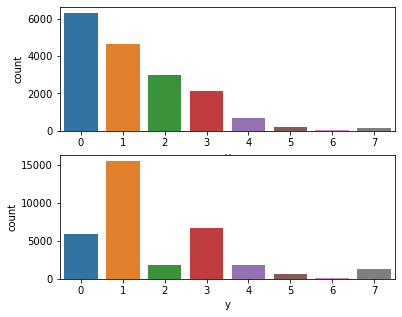

In [19]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [20]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [21]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.35960841613628086, 0.16426335340188197)

In [22]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"084_submission.csv","GroupK-Fold(batterID)","0.359608","0.164263","","XGBoostベクトルは除外しBatterIDでGroupKFold"


In [23]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 33 s


In [24]:
imp_df

,feature,importance,fold
0,totalPitchingCount,0.005162,1
1,B,0.008450,1
2,S,0.011158,1
3,O,0.010746,1
4,inningNo,0.005390,1
...,...,...,...
114,batterTeam,0.003697,10
115,pitcherTeam,0.012759,10
116,b1,0.007028,10
117,b2,0.009566,10


In [25]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [26]:
coef_df

""
